In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib.colors as colors

In [4]:
from scipy.optimize import curve_fit

In [5]:
import pandas as pd

In [6]:
from scipy.stats import t

In [7]:
from scipy import stats

In [8]:
def window_average(arr,n):
    ret = np.cumsum(arr, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]/n

In [9]:
nstates = 12
color_list = plt.cm.Set3
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in range(nstates)]
#clist = [cs[int(i)] for i in np.linspace(1,len(cs)-1,nstates)]
clist = clist[::-1]

In [10]:
def PolyRegression1D(x, y, degree = 1, intercept = True):
    """one dimensional (y is a single variable function of x) fitting using an n-degree polynomial
    
    RETURNS: a dictionary 
    KEY  , VALUE
    
    ypred , estimated y values based on regression result (np.ndarray)
    co-effs , co-efficients for each degree of the polynomial in increasing order (np.ndarray)
    r2 , the r-squared value from the fit (float)
    y_residuals , difference between actual y data and the predicted y data
    
    ADDITIONAL RETURNS FOR DEGREE == 1 (fitting a line)
    
    slope_error , uncertainty in the predicted slope
    int_error , uncertainty in the predicted y-intercept
    
    """
    X = []
    if intercept:
        start = 0
    else:
        start = 1
    for i in range(start,degree+1):
        X.append(x**i)
    X = np.stack(X, axis = 1) #make matrix to solve co-efficients of
    b = np.linalg.inv(X.T@X)@X.T@y #solve for co-efficients
    yhat = (X@b.reshape(-1,1)).flatten() #predict y-values based on co-efficients
    yres = y-yhat #get y residuals
    yres2 = yres**2 #get squared residuals
    yvar = (y-y.mean())**2 #get un-normalized variance of y
    r2 = 1 - (yres2.sum()/yvar.sum()) #compute r-squared
    print(yvar.shape,yres2.shape)
    if degree == 1:
        """compute error of slope and intercept if applicable"""
        x2 = x**2
        slope_error = np.sqrt(np.sum(yres2)/((len(x)-2)*np.sum((x-x.mean())**2)))
        int_error = np.sqrt((np.sum(yres2)*x2.sum())/((len(x)-2)*len(x)*np.sum((x-x.mean())**2)))
        return dict(zip("ypred,co-effs,r2,y_residuals,slope_error,int_error".split(","),
                        [yhat,b,r2,yres,slope_error,int_error]))
    else:
        return dict(zip("ypred,co-effs,r2,y_residuals".split(","),[yhat, b, r2, yres]))

In [11]:
def pooled_sd(means:"1d array of trial means", sds:"1d array of trial sds",
              n_samples:"1d array of the number of samples used to estimate each sd and mean" = None,):
    """
    For combining standard deviations.
    
    
    Can be used for combining standard deviations estimated from datasets with differing number of samples.
    
    If n_samples if None or a constant, then it's assumed that the number of samples is the same for all SDs and cancels out of the sum and reduces to the number of standard deviations 
    being combined. As a result, this parameter can be left as None if all standard deviations are estimated using the same number of samples
    
    """
    if isinstance(n_samples, (float, int)) or n_samples is None:
        #in this case the number of samples cancels out
        return np.sqrt((sds**2 + (means - means.mean())**2).sum()/len(means))
    else:
        n = n_samples.sum()
        return np.sqrt((n_samples*(sds**2 + (means - means.mean())**2)).sum()/n)

In [12]:
def make_symbols():
    unicharacters = ["\u03B1",
                        "\u03B2",
                        "\u03B3",
                        "\u03B4",
                        "\u03B5",
                        "\u03B6",
                        "\u03B7",
                        "\u03B8",
                        "\u03B9",
                        "\u03BA",
                        "\u03BB",
                        "\u03BC",
                        "\u03BD",
                        "\u03BE",
                        "\u03BF",
                        "\u03C0",
                        "\u03C1",
                        "\u03C2",
                        "\u03C3",
                        "\u03C4",
                        "\u03C5",
                        "\u03C6",
                        "\u03C7",
                        "\u03C8",
                        "\u03C9",
                        "\u00C5"]
    keys = "alpha,beta,gamma,delta,epsilon,zeta,eta,theta,iota,kappa,lambda,mu,nu,xi,omicron,pi,rho,final_sigma,sigma,tau,upsilon,phi,chi,psi,omega,angstrom"
    return dict(zip(keys.split(","),unicharacters))
symbols = make_symbols()

In [13]:
def fit_biexponential(ac_timeseries):
    """Fit a biexponential function to a hydrogen bond time autocorrelation function
    Return the two time constants
    """
    from scipy.optimize import curve_fit

    def model(t, A, tau1):
        """Fit data to a exponential function.
        """
        return A * np.exp(-t / tau1)
    tau_timeseries=np.linspace(0,100,401)
    try:
        tf_e = np.where(ac_timeseries<np.exp(-1))[0][0]
    except:
        tf_e = -1
    
    ac_timeseries2 = ac_timeseries[1:tf_e]
    tau_timeseries2 = tau_timeseries[1:tf_e]
    params, params_covariance = curve_fit(model, tau_timeseries2, ac_timeseries2, [0.8, 5.0], method='trf')

    fit_t = tau_timeseries2
    fit_ac = model(tau_timeseries2, *params)
    
    params_fit = np.sqrt(np.diag(params_covariance))

    return np.array([params[-1], params_fit[-1], len(fit_t)])

In [14]:
def fit_biexponential(ac_timeseries):
    """Fit a biexponential function to a hydrogen bond time autocorrelation function
    Return the two time constants
    """
    from scipy.optimize import curve_fit

    def model(t, A, tau1):
        """Fit data to a exponential function.
        """
        return A * np.exp(-t / tau1)
    tau_timeseries=np.linspace(0,100,401)
    tf_e = ac_timeseries>np.exp(-1)
    temp = tf_e
    check=True
    for i in range(len(tf_e)):

        if tf_e[i]==0:
            check = False
        if not check:
            temp[i]=0
    tf_e = temp
    
    ac_timeseries2 = ac_timeseries[tf_e][1:]
    tau_timeseries2 = tau_timeseries[tf_e][1:]
    params, params_covariance = curve_fit(model, tau_timeseries2, ac_timeseries2, [0.8, 5.0], method='trf')

    fit_t = tau_timeseries2
    fit_ac = model(tau_timeseries2, *params)
    
    params_fit = np.sqrt(np.diag(params_covariance))

    return np.array([params[-1], params_fit[-1], len(fit_t)])

In [15]:
def moving_average(x, y, prop=0.1, step=0.05, minmax=None):
    import numpy as np
    x_out,y_out = [],[]
    n = []
    if minmax:
        i = minmax[0]
        o = minmax[1]
    else:
        i = np.min(x)
        o = np.max(x)
    data_width = o - i
    window_len = data_width*prop
    lag = data_width*step
    last_window = data_width - window_len
    while i <= last_window:
        TF = ( x >= i ) & ( x < i + window_len )
        check = np.sum(TF)
        if check:
            n.append(check)
            x_append = np.mean(x[TF])
            x_out.append(x_append)
            
            y_append = np.mean(y[TF])
            y_out.append(y_append)
            
        i += lag
    out_array = np.array(list(zip(x_out,y_out)))
    
    return [out_array, n]

In [16]:
def moving_average_ptype(x,y,z,prop=0.1,step=0.05,minmax=None,composition=['r'],debug=False):
    import numpy as np
    x_out,y_out,z_out = [],[],[]
    if minmax:
        i = minmax[0]
        o = minmax[1]
    else:
        i = np.min(x)
        o = np.max(x)
    data_width = o - i
    window_len = data_width*prop
    lag = data_width*step
    last_window = data_width - window_len
    while i <= last_window:
        TF = ( x >= i ) & ( x < i + window_len )
        if np.sum(TF):
            if debug: print(len(x[TF]),len(y[TF]))
            x_append = np.mean(x[TF])
            x_out.append(x_append)
            y_append = np.mean(y[TF])
            y_out.append(y_append)
            z_append = float(np.sum([ 1 if i in composition else 0 for i in z[TF] ]))/float(len(z[TF]))
            if debug:  print(z_append)

            z_out.append(z_append)
        i += lag
    if debug: print('finished window averaging')
    out_array = np.array(list(zip(x_out,y_out,z_out)))
    if debug: print(out_array)
    return out_array

# SUMO-1 Data

In [17]:
# residues lacking hydrogen bonding information
no_hbond = [24,26,64,76,88]
resnum2idx = np.array([i for i in range(3,97) if i not in no_hbond])
#load residue acf
res_hbac = np.array([np.loadtxt(f'./SUMO1/acf_550/res{i}.dat') for i in range(3,97) if i not in [24,26,64,76,88]])

In [18]:
tau_err = np.concatenate([resnum2idx.reshape(-1,1),np.apply_along_axis(func1d=fit_biexponential, axis=1, arr = res_hbac)],axis = 1)

In [19]:
pd_saveit = pd.DataFrame(tau_err[:,1:],columns=[symbols['tau'],symbols['sigma'],'length'], index=tau_err[:,0])
pd_saveit['pm'] = [f'{i:0.3f} \u00B1 {j:0.3f}' for i,j in tau_err[:,1:3]]
pd_saveit.to_excel('./SUMO-1_tau_tauerror.xls')

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
pd_saveit.sort_values(symbols['tau'])

,τ,σ,length,pm
57.0,5.081765,0.237022,15.0,5.082 ± 0.237
56.0,5.676025,0.238206,18.0,5.676 ± 0.238
65.0,6.398942,0.272451,18.0,6.399 ± 0.272
8.0,6.732774,0.265247,21.0,6.733 ± 0.265
58.0,6.871027,0.272897,22.0,6.871 ± 0.273
...,...,...,...,...
77.0,56.719994,1.457738,147.0,56.720 ± 1.458
90.0,64.362476,1.121421,222.0,64.362 ± 1.121
73.0,80.350058,1.020024,282.0,80.350 ± 1.020
86.0,80.438752,0.512677,283.0,80.439 ± 0.513


In [21]:
tau_err_stack = np.stack([np.concatenate([resnum2idx.reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, arr = np.array([np.loadtxt(f'./SUMO1/acf_{j}/res{i}.dat') for i in resnum2idx]) )],axis = 1) for j in np.arange(1,11)*55])

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# $C_{HB}(t)$ for select residues lower figure for manuscript
# Upper figure displays all residue convergence of SUMO-1

# $SUMO-1\; \tau_{HB}\; Analysis$

In [22]:
ymax = np.array([40,40,40,60,200,50,90,90,70])
length = np.arange(1,11)*5.5

$\mathbf{Figure\; 1}$

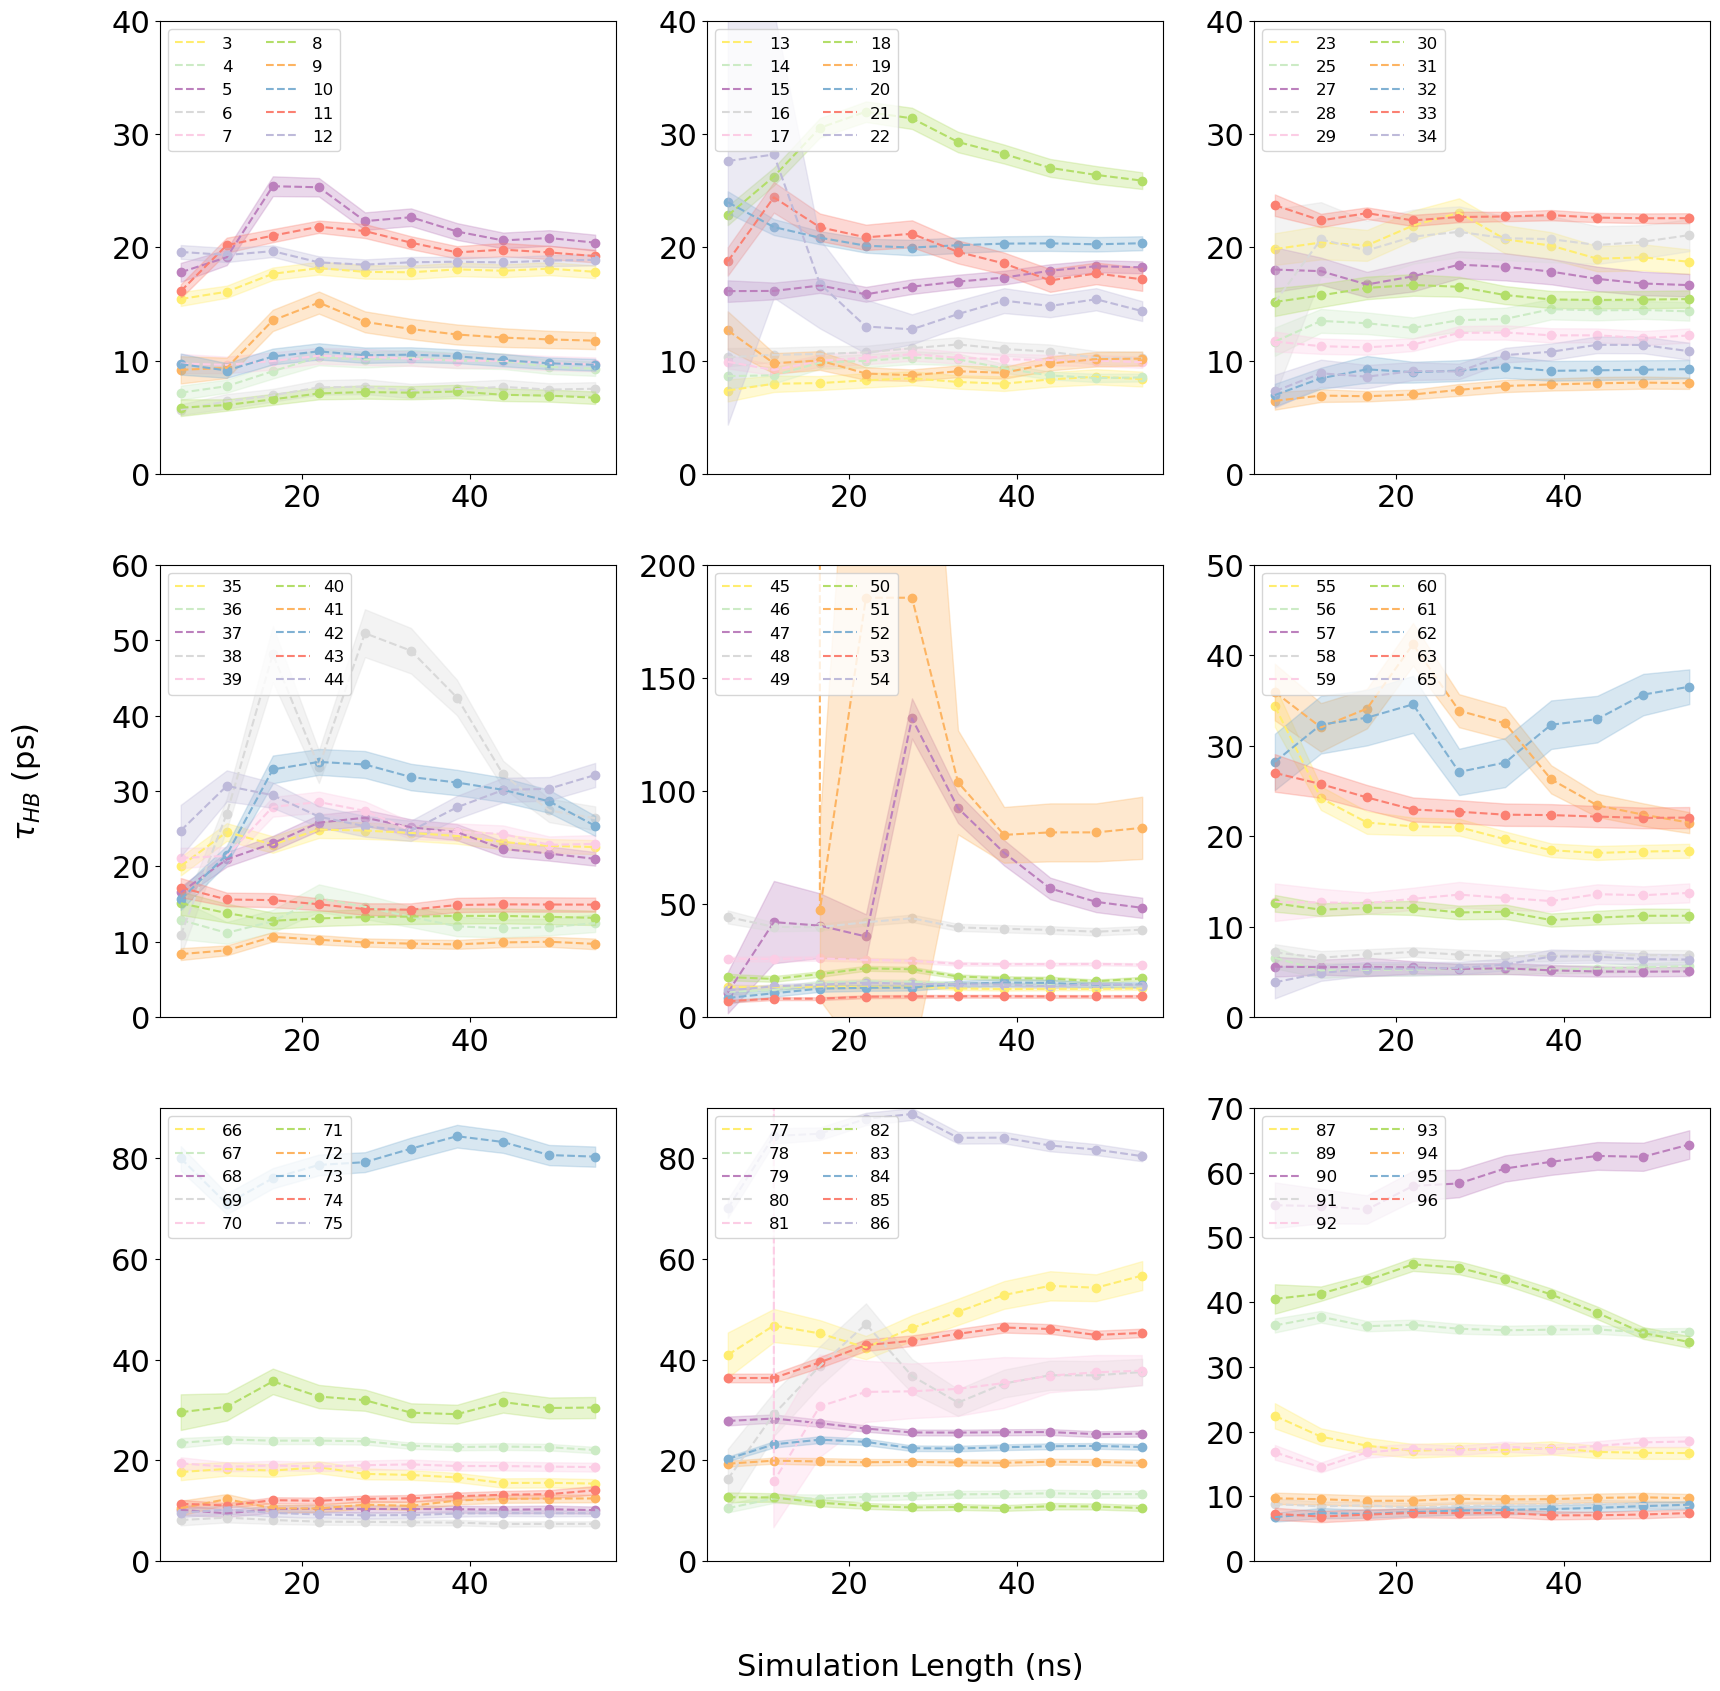

In [23]:
fig, axes = plt.subplots(3,3, figsize=(20,20))
for ax, y_max, arr in zip(axes.flat, ymax, np.array_split(tau_err_stack.transpose(1,2,0),9)):
    for k,i in enumerate(arr):
        ax.plot(length,i[1], label=int(i[0][0]), c=clist[k],ls='--')
        ax.scatter(length,i[1], color=clist[k])
        # get the 95% confidence interval
        t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
        ax.fill_between(length,i[1]+t_interval,i[1]-t_interval, alpha=0.3, color=clist[k])
        ax.set_ylim(0,y_max)
        ax.tick_params(labelsize=22)
    ax.legend(ncol = 2,fontsize=12,loc='upper left')

fig.supxlabel('Simulation Length (ns)',x=0.5, y=0.05, size=22)
fig.supylabel(r'$\tau_{HB}$ (ps)', x=0.05, y=0.5, size =22)
plt.savefig('./simlength_v_tau_all_sumo1.png',dpi=300)

$\mathbf{Figure\; 2}$

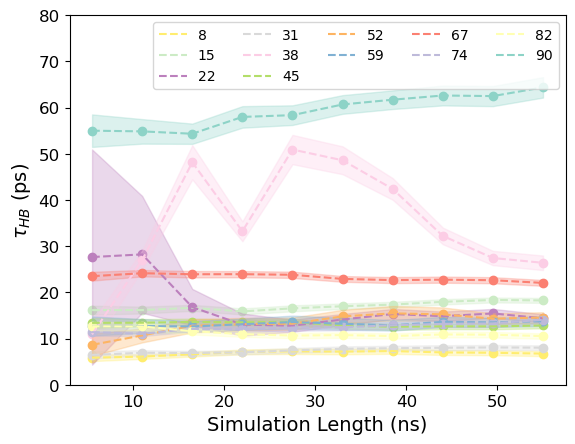

In [24]:
#### np.array_split(tau_err_stack.transpose(1,2,0),9)
for k,i in enumerate(tau_err_stack.transpose(1,2,0)[5:][::7]):
    plt.plot(length,i[1], label=int(i[0][0]),c=clist[k],ls='--')
    plt.scatter(length,i[1],color=clist[k])
    t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
    plt.fill_between(length,i[1]+t_interval,i[1]-t_interval, alpha=0.3, color=clist[k])
    plt.ylim(0,y_max)
plt.ylim(0,80)
plt.tick_params(labelsize=12)
plt.legend(ncol = 5, loc='upper right')
plt.xlabel('Simulation Length (ns)',size=14)
plt.ylabel(r'$\tau_{HB}$ (ps)',size=14)
plt.savefig('simlength_v_tau_sumo1.png',dpi=300)

Examples of hydrogen bond correlation err from poor convergence for SUMO-1

In [25]:
removed_residues = np.array([26,64,76,88])

tau_err_stack_sumo1_removed1 = np.stack([np.concatenate([np.array([26]).reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, arr =  np.array([np.loadtxt(f'./SUMO1/acf_{j}/res{i}.dat') for i in [26] ]) )], axis = 1) for j in np.arange(6,11)*55])
tau_err_stack_sumo1_removed2 = np.stack([np.concatenate([np.array([76]).reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, arr =  np.array([np.loadtxt(f'./SUMO1/acf_{j}/res{i}.dat') for i in [76] ]) )], axis = 1) for j in np.arange(1,11)*55])
tau_err_stack_sumo1_removed3 = np.stack([np.concatenate([np.array([88]).reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, arr =  np.array([np.loadtxt(f'./SUMO1/acf_{j}/res{i}.dat') for i in [88] ]) )], axis = 1) for j in np.arange(10,11)*55])

$\mathbf{Figure\; 3}$

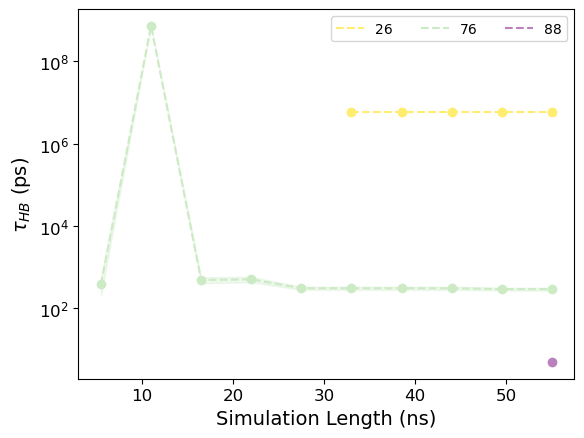

In [26]:


k = 0
i = tau_err_stack_sumo1_removed1.transpose(1,2,0)[0]
plt.semilogy(length[5:],i[1], label=int(i[0][0]),c=clist[k],ls='--')
plt.scatter(length[5:],i[1],color=clist[k])
t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
plt.fill_between(length[5:],i[1]+t_interval,i[1]-t_interval, where=~np.isnan(i[2]),alpha=0.3, color=clist[k])

for k,i in enumerate(tau_err_stack_sumo1_removed2.transpose(1,2,0)):
    plt.semilogy(length,i[1], label=int(i[0][0]),c=clist[k+1],ls='--')
    plt.scatter(length,i[1],color=clist[k+1])
    t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
    plt.fill_between(length,i[1]+t_interval,i[1]-t_interval, alpha=0.3, color=clist[k+1])
    
    
k = 2
i = tau_err_stack_sumo1_removed3.transpose(1,2,0)[0]
plt.semilogy(length[9:],i[1], label=int(i[0][0]),c=clist[k],ls='--')
plt.scatter(length[9:],i[1],color=clist[k])
t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
plt.fill_between(length[9:],i[1]+t_interval,i[1]-t_interval, where=~np.isnan(i[2]),alpha=0.3, color=clist[k])

plt.tick_params(labelsize=12)
plt.legend(ncol = 5, loc='upper right')
plt.xlabel('Simulation Length (ns)',size=14)
plt.ylabel(r'$\tau_{HB}$ (ps)',size=14)
plt.savefig('simlength_v_tau_failed-convergence_sumo1.png',dpi=300)

Caption

Regions without shading correspond to regions where the error of $\tau_{HB}$ approaches infinity. 

For example the first two simulation lengths, 5.5 and 11 ns,  are missing a confidence interval for Residue 76. 

Missing points correspond to regions missing hydrogen bond information, e.g. Residue 26 up to 33 ns. 

Each point indicates the total length of the simulation from 0 ns to T ns evaluated to compute the ACF and subsequently

fit $e^{-t/\tau}$ out to $\frac{1}{e}$ using non-linear least squares fit. 

Regions without shading correspond to regions where the error of $\tau_{HB}$ approaches infinit. 


# UBC9 Data

In [27]:
#Residues lacking hydrogen bond information
no_hbond_ubc9 = [9,12,26,41,45,53,58,60,62,68,75,77,83,84,85,86,90,93,109,112,113,116,120,133,144,148]
resnum2idx_ubc9 = np.array([i for i in range(1,158) if i not in no_hbond_ubc9])
# Load ACF functions
res_hbac_ubc9 = np.array([np.loadtxt(f'./UBC9/acf_550/res{i}.dat') for i in range(1,158) if i not in no_hbond_ubc9])

In [28]:
# compute tau, tau_err for each residue
tau_err_ubc9 = np.concatenate([resnum2idx_ubc9.reshape(-1,1),np.apply_along_axis(func1d=fit_biexponential, axis=1, arr = res_hbac_ubc9)],axis = 1)

In [29]:
pd_saveit_ubc9 = pd.DataFrame(tau_err_ubc9[:,1:],columns=[symbols['tau'],symbols['sigma'],'length'], index=tau_err_ubc9[:,0])
pd_saveit_ubc9['pm'] = [f'{i:0.3f} \u00B1 {j:0.3f}' for i,j in tau_err_ubc9[:,1:3]]
pd_saveit_ubc9.to_excel('./UBC9_tau_tauerror.xls')

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
pd_saveit_ubc9.sort_values(symbols['tau'])

,τ,σ,length,pm
44.0,4.578575,0.743186,7.0,4.579 ± 0.743
10.0,5.486864,0.337823,16.0,5.487 ± 0.338
32.0,5.614469,0.226110,17.0,5.614 ± 0.226
50.0,5.904398,0.180095,20.0,5.904 ± 0.180
138.0,6.174843,0.269608,20.0,6.175 ± 0.270
...,...,...,...,...
94.0,62.919287,1.058059,189.0,62.919 ± 1.058
72.0,65.326306,1.190270,206.0,65.326 ± 1.190
127.0,74.301778,0.835851,260.0,74.302 ± 0.836
92.0,78.657126,1.341721,204.0,78.657 ± 1.342


In [31]:
tau_err_stack_ubc9 = np.stack([np.concatenate([resnum2idx_ubc9.reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, 
            arr = np.array([np.loadtxt(f'./UBC9/acf_{j}/res{i}.dat') for i in resnum2idx_ubc9]) )],axis = 1) for j in np.arange(1,11)*55])

# $C_{HB}(t)$ for select residues lower figure for manuscript
# Upper figure displays all residue convergence of UBC9

# $UBC9\; \tau_{HB}\; Analysis$

In [32]:
ymax = np.array([60,40,60,60,200,80,100,100,70,100,50,50])
length = np.arange(1,11)*5.5

$\mathbf{Figure\; 4}$

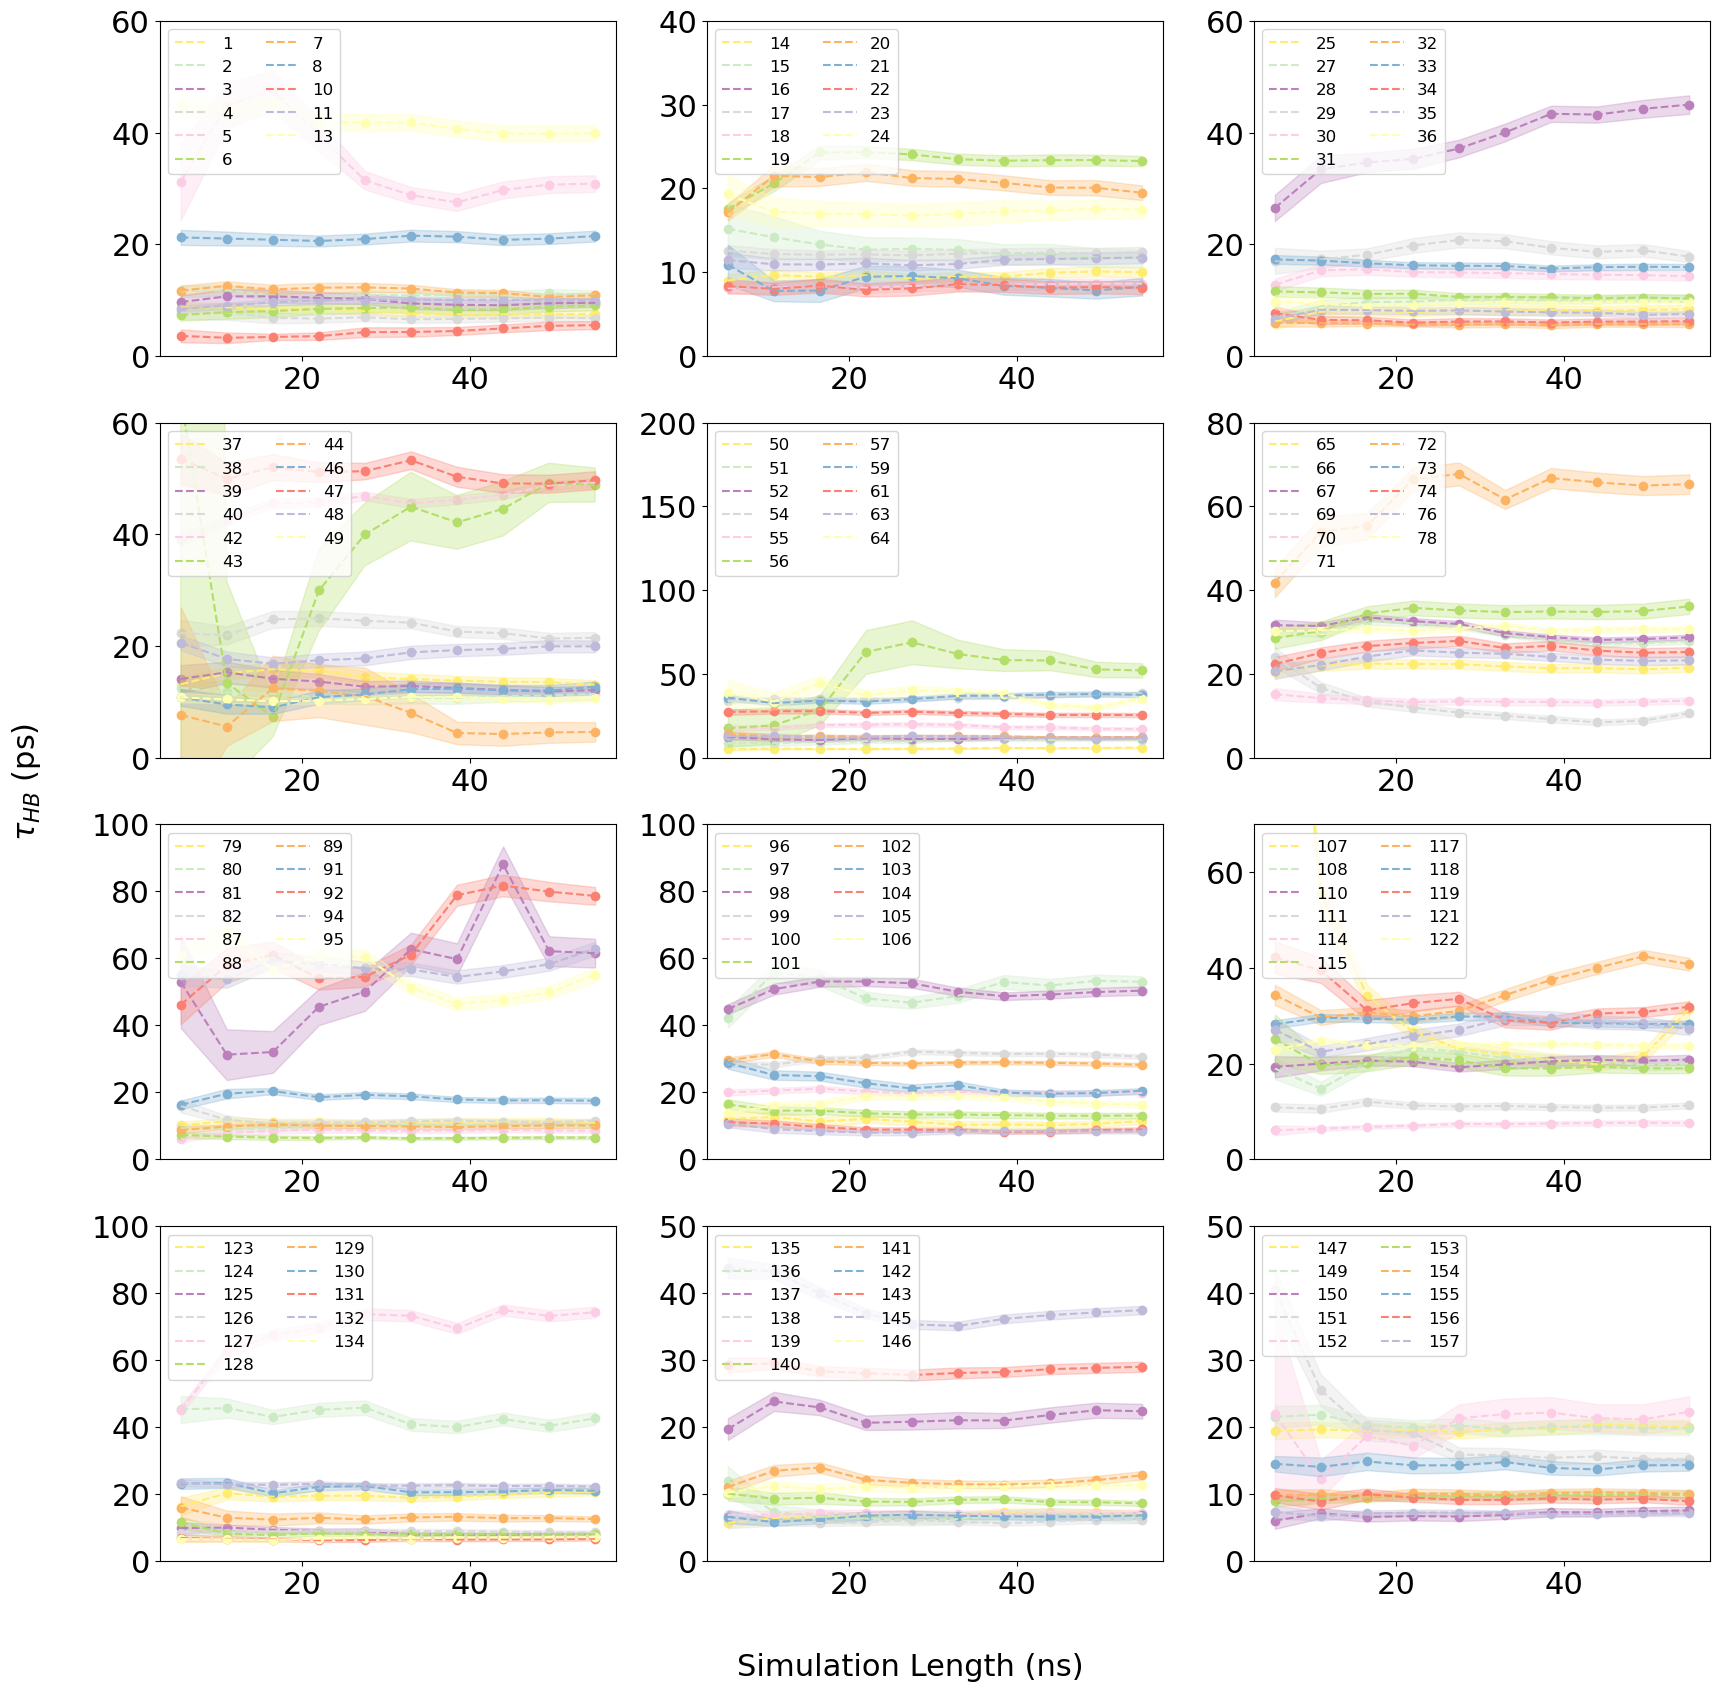

In [33]:
fig, axes = plt.subplots(4,3, figsize=(20,20))
for ax, y_max, arr in zip(axes.flat, ymax, np.array_split(tau_err_stack_ubc9.transpose(1,2,0),12)):
    for k,i in enumerate(arr):
        ax.plot(length,i[1], label=int(i[0][0]), c=clist[k],ls='--')
        ax.scatter(length,i[1], color=clist[k])
        # get the 95% confidence interval
        t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
        ax.fill_between(length,i[1]+t_interval,i[1]-t_interval, alpha=0.3, color=clist[k])
        ax.set_ylim(0,y_max)
        ax.tick_params(labelsize=22)
    ax.legend(ncol = 2,fontsize=12,loc='upper left')

fig.supxlabel('Simulation Length (ns)',x=0.5, y=0.05, size=22)
fig.supylabel(r'$\tau_{HB}$ (ps)', x=0.05, y=0.5, size =22)
plt.savefig('./simlength_v_tau_all_ubc9.png',dpi=300)

$\mathbf{Figure\; 5}$

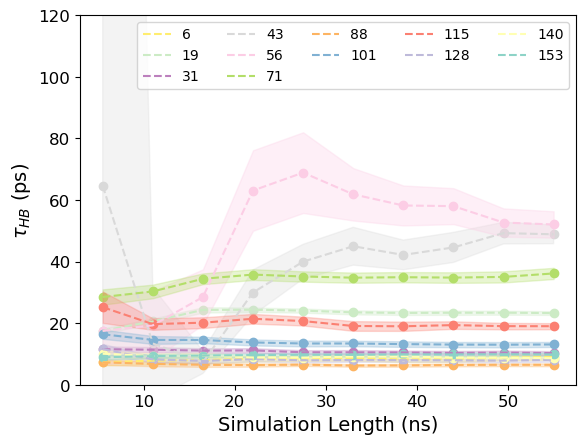

In [34]:
#### np.array_split(tau_err_stack.transpose(1,2,0),9)
for k,i in enumerate(tau_err_stack_ubc9.transpose(1,2,0)[5:][::11]):
    plt.plot(length,i[1], label=int(i[0][0]),c=clist[k],ls='--')
    plt.scatter(length,i[1],color=clist[k])
    t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
    plt.fill_between(length,i[1]+t_interval,i[1]-t_interval, alpha=0.3, color=clist[k])
    plt.ylim(0,y_max)
plt.ylim(0,120)
plt.tick_params(labelsize=12)
plt.legend(ncol = 5, loc='upper right')
plt.xlabel('Simulation Length (ns)',size=14)
plt.ylabel(r'$\tau_{HB}$ (ps)',size=14)
plt.savefig('simlength_v_tau_sumo1.png',dpi=300)

Examples of hydrogen bond correlation err from poor convergence for UBC9

In [35]:
removed_residues = np.array([60,62,90,133])
tau_err_stack_ubc9_removed = np.stack([np.concatenate([np.array([60,62]).reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, arr =  np.array([np.loadtxt(f'./UBC9/acf_{j}/res{i}.dat') for i in [60,62] ]) )], axis = 1) for j in np.arange(1,11)*55])
tau_err_stack_ubc9_removed1 = np.stack([np.concatenate([np.array([90]).reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, arr =  np.array([np.loadtxt(f'./UBC9/acf_{j}/res{i}.dat') for i in [90] ]) )], axis = 1) for j in np.arange(5,11)*55])
tau_err_stack_ubc9_removed2 = np.stack([np.concatenate([np.array([133]).reshape(-1,1),
        np.apply_along_axis(func1d=fit_biexponential, axis=1, arr =  np.array([np.loadtxt(f'./UBC9/acf_{j}/res{i}.dat') for i in [133] ]) )], axis = 1) for j in np.arange(2,11)*55])

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


$\mathbf{Figure\; 6}$

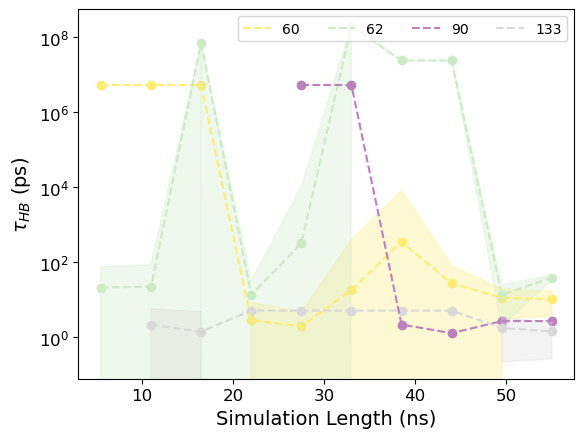

In [36]:
for k,i in enumerate(tau_err_stack_ubc9_removed.transpose(1,2,0)):
    plt.semilogy(length,i[1], label=int(i[0][0]),c=clist[k],ls='--')
    plt.scatter(length,i[1],color=clist[k])
    t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
    plt.fill_between(length,i[1]+t_interval,i[1]-t_interval, alpha=0.3, color=clist[k])


k = 2
i = tau_err_stack_ubc9_removed1.transpose(1,2,0)[0]
plt.semilogy(length[4:],i[1], label=int(i[0][0]),c=clist[k],ls='--')
plt.scatter(length[4:],i[1],color=clist[k])
t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
plt.fill_between(length[4:],i[1]+t_interval,i[1]-t_interval, where=~np.isnan(i[2]),alpha=0.3, color=clist[k])

k,i = 3,tau_err_stack_ubc9_removed2.transpose(1,2,0)[0]
plt.semilogy(length[1:],i[1], label=int(i[0][0]),c=clist[k],ls='--')
plt.scatter(length[1:],i[1],color=clist[k])
t_interval = t.interval(alpha=0.95, df=i[3], scale=i[2])[1]
plt.fill_between(length[1:],i[1]+t_interval,i[1]-t_interval, where=~np.isnan(i[2]), alpha=0.3, color=clist[k])


plt.tick_params(labelsize=12)
plt.legend(ncol = 5, loc='upper right')
plt.xlabel('Simulation Length (ns)',size=14)
plt.ylabel(r'$\tau_{HB}$ (ps)',size=14)
plt.savefig('simlength_v_tau_failed-convergence_ubc9.png',dpi=300)

Caption

Regions without shading correspond to regions where the error of $\tau_{HB}$ approaches infinity. 

For example the first three simulation lengths, 5.5, 11 and 16.5 ns,  are missing a confidence interval. 

Missing points correspond to regions missing hydrogen bond information, e.g. Residue 90 up to 22 ns. 

Each point indicates the total length of the simulation from 0 ns to T ns evaluated to compute the ACF and subsequently

fit $e^{-t/\tau}$ out to $\frac{1}{e}$ using non-linear least squares fit. 



# RSA v $\tau_{HB}$ with respect to various properties

In [37]:
res_to_elect = {'ARG':'b','HSD':'b','HSE':'b','LYS':'b','ASP':'r','GLU':'r','SER':'g','THR':'g','ASN':'g','GLN':'g','CYS':'white','GLY':'g','PRO':'white','ALA':'white','VAL':'white','ILE':'white', 'LEU':'white', 'MET':'white', 'PHE':'white','TYR':'white','TRP':'white'}
markers={'HELIX':'o','BETA':'^','IDR':'s','LOOP':'D'}
rtype={'HELIX':'o','BETA':'^','IDR':'s','LOOP':'D'}
labels = {'r':'Anionic','b':'Cationic','g':'Polar','white':'Non-polar'}
label_it = {'HELIX': r'$\alpha$-helix', 'BETA': r'$\beta$-sheet', 'IDR':'IDR', 'LOOP':'Loop'}
# dictionary for retardation factors
ret_factors = {'sumo1':{},'ubc9':{}}

# SUMO-1

In [38]:
reg_struct = pd.read_csv('./SUMO1/regions_structure.txt')

In [39]:
sumo1_df = pd.read_csv('./SUMO1/RSA_res_name_type.csv')
sumo1_df.drop(columns='Unnamed: 0',inplace=True)
sumo1_df[symbols['tau']] = pd_saveit[symbols['tau']].values
sumo1_df[symbols['sigma']] = pd_saveit[symbols['sigma']].values
sumo1_df['ci_99'] = t.interval(alpha=0.99, scale=pd_saveit[symbols['sigma']].values, df = tau_err_stack.transpose(1,2,0)[:,-1,-1])[-1]
sumo1_df['struct'] = [j[0] for i in sumo1_df['residue'].values for j in reg_struct.values if i>=j[1] and i<=j[2]]
sumo1_df['shape'] = [ markers[i] for i in sumo1_df['struct'].values]
sumo1_df['electro'] = [ res_to_elect[i] for i in sumo1_df['name'].values ]
sumo1_df.to_csv('./sumo1_figure_data_tabulated.xls')

In [40]:
reg_struct

,struct,start,end
0,IDR,2,20
1,BETA,21,28
2,LOOP,29,31
3,BETA,32,39
4,LOOP,40,43
5,HELIX,44,55
6,IDR,56,61
7,BETA,62,65
8,IDR,66,85
9,BETA,86,92


Reported here with error bars is the 99% confidence interval of

$tau_{HB}$ for the full lentgh trajectory

$\mathbf{Figure\; 7}$

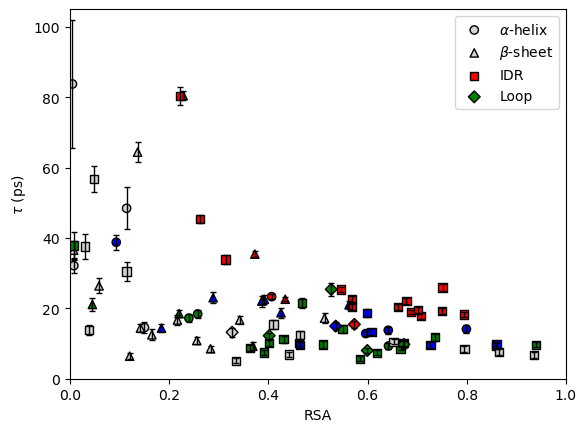

In [41]:
dfout = pd.DataFrame()
for i in ['HELIX','BETA','IDR','LOOP']:
    dfout_temp = pd.DataFrame()
    TF =  ( sumo1_df['struct']==i )
    x = sumo1_df[TF][symbols['tau']].values
    xerr = sumo1_df[TF]['ci_99'].values
    y = sumo1_df[TF]['RSA'].values
    z = sumo1_df[TF]['residue'].values
    z2 = sumo1_df[TF]['name'].values
    z3 = list(map(lambda k: labels[k], sumo1_df[TF]['electro'].values))

    color_it = sumo1_df[TF]['electro'].values
    temp = []
    for colour in color_it:
        if colour != 'white': temp.append(colour)
        else: temp.append('lightgray')
    plt.errorbar(y, x, yerr=xerr, color='white', alpha=1, ecolor='k', capsize=2, linewidth=0, elinewidth=1)
    plt.scatter(y, x, c=temp , marker=markers[i], label=label_it[i], edgecolors='k')
    dfout_temp = pd.DataFrame()
    dfout_temp['tau']=x
    dfout_temp['RSA']=y
    dfout_temp['residue']=z
    dfout_temp['number']=z2
    dfout_temp['type']=z3
    dfout = pd.concat([dfout,dfout_temp], ignore_index=True, sort=False)
dfout.to_csv('./tau_v_RSA_colorbyelectro-sumo1.csv')
plt.ylim(0,105)
plt.xlim(0,1)
plt.xlabel('RSA')
plt.ylabel(r'$\tau$ (ps)')
plt.legend()
plt.savefig('./tau_v_RSA_colorbyelectro-sumo1.png',dpi= 300)

$\mathbf{Figure\; 8}$

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


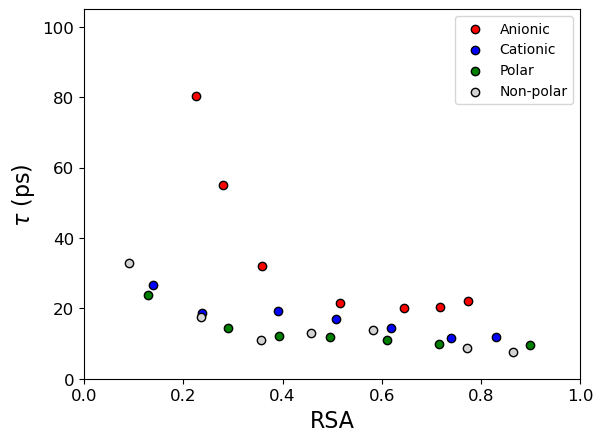

In [42]:
dict_MW_electro_sumo1 = {}
for i in ['r','b','g','white']:
    TF = ( sumo1_df['electro']==i )
    y = sumo1_df[TF][symbols['tau']].values
    x = sumo1_df[TF]['RSA'].values
    
    xy, n = moving_average(x,y,0.25,0.125,[0.0,1.0])
    n = np.array(n)
    x,y = xy.T

    if i!='white': plt.scatter(x, y, c=i , marker='o', label=labels[i], edgecolors='k', alpha=1)
    else: plt.scatter(x, y, c='lightgrey' , marker='o', label=labels[i], edgecolors='k', alpha=1)

    dict_MW_electro_sumo1[i]=np.array([x, y, n, i*len(y)])
plt.ylim(0,105)
plt.xlim(0,1)
plt.tick_params(labelsize=12)
plt.xlabel('RSA',size=16)
plt.ylabel(r'$\tau$ (ps)',size=16)
plt.legend()
plt.savefig('./tau_v_RSA_MW_colorbyelectro-sumo1.png',dpi= 300)

$\mathbf{Figure\; 9}$

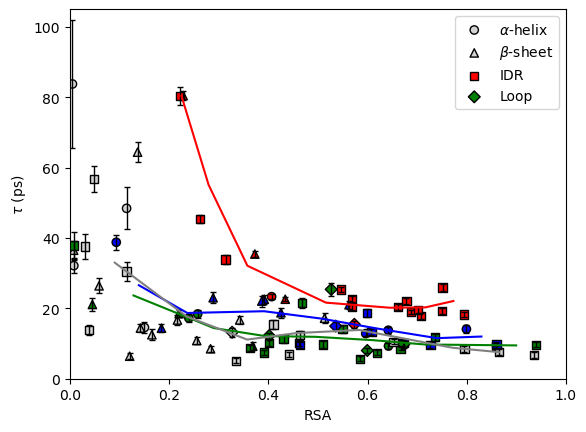

In [43]:
for i in ['HELIX','BETA','IDR','LOOP']:
    TF =  ( sumo1_df['struct']==i )
    x = sumo1_df[TF][symbols['tau']].values
    xerr = sumo1_df[TF]['ci_99'].values
    y = sumo1_df[TF]['RSA'].values

    color_it = sumo1_df[TF]['electro'].values
    temp = []
    for colour in color_it:
        if colour != 'white': temp.append(colour)
        else: temp.append('lightgray')
    # Plot data points and 99% confidence interval
    plt.errorbar(y, x, yerr=xerr, alpha=1, ecolor='k', capsize=2, linewidth=0, elinewidth=1)
    plt.scatter(y, x, c=temp , marker=markers[i], label=label_it[i], edgecolors='k')
    
#plot moving window average
for i in ['r','b','g','white']:
    if i != 'white': plt.plot(dict_MW_electro_sumo1[i][0],dict_MW_electro_sumo1[i][1], c = i)
    else: plt.plot(dict_MW_electro_sumo1[i][0],dict_MW_electro_sumo1[i][1], c = 'grey')

plt.ylim(0,105)
plt.xlim(0,1)
plt.xlabel('RSA')
plt.ylabel(r'$\tau$ (ps)')
plt.legend()
plt.savefig('./tau_v_RSA_colorbyelectro_withMW_withCI99-sumo1.png',dpi= 300)

$\mathbf{Figure\; 10}$

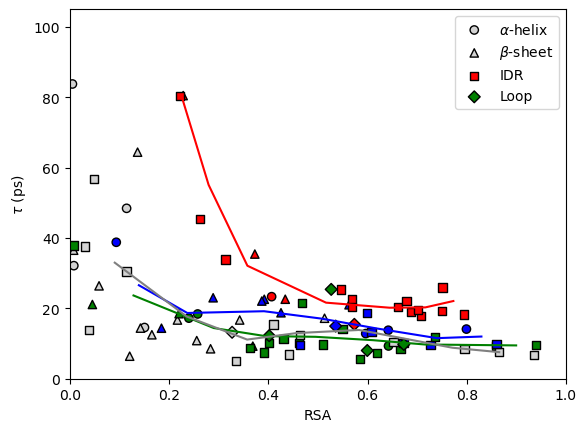

In [44]:
dfout = pd.DataFrame()
for i in ['HELIX','BETA','IDR','LOOP']:

    TF =  ( sumo1_df['struct']==i )
    x = sumo1_df[TF][symbols['tau']].values
    y = sumo1_df[TF]['RSA'].values

    color_it = sumo1_df[TF]['electro'].values
    temp = []
    for colour in color_it:
        if colour != 'white': temp.append(colour)
        else: temp.append('lightgray')
    # Plot data without 99% CI
    plt.scatter(y, x, c=temp , marker=markers[i], label=label_it[i], edgecolors='k')

#plot moving window average
for i in ['r','b','g','white']:
    if i != 'white': plt.plot(dict_MW_electro_sumo1[i][0],dict_MW_electro_sumo1[i][1], c = i)
    else: plt.plot(dict_MW_electro_sumo1[i][0],dict_MW_electro_sumo1[i][1], c = 'grey')

plt.ylim(0,105)
plt.xlim(0,1)
plt.xlabel('RSA')
plt.ylabel(r'$\tau$ (ps)')
plt.legend()
plt.savefig('./tau_v_RSA_colorbyelectro_withMW_withCI-sumo1.png',dpi= 300)

$\mathbf{Figure\; 11}$

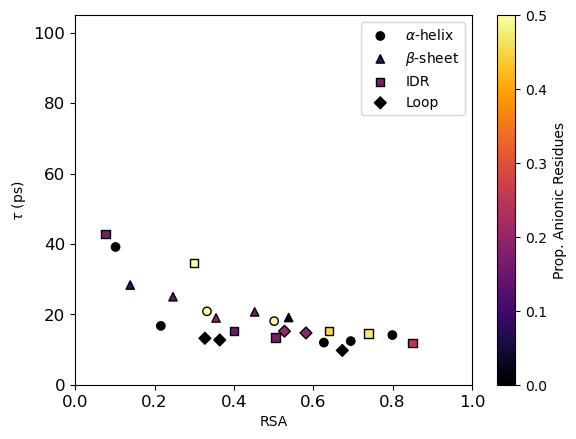

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in label_it:
    TF = (sumo1_df[symbols['tau']]>0.0) & ( sumo1_df['struct']==i )
    x = sumo1_df[TF][symbols['tau']].values
    y = sumo1_df[TF]['RSA'].values
    z = sumo1_df[TF]['electro'].values
    y, x, z = moving_average_ptype(y, x, z, 0.25, 0.125, [0.0,1.0]).T
    plt.scatter(y, x, c=z, cmap="inferno", marker=markers[i], label=label_it[i], edgecolors='k', vmax=0.5, vmin=0)


plt.ylim(0,105)
plt.xlim(0,1)
plt.tick_params(labelsize=12)
plt.xlabel('RSA')
plt.ylabel(r'$\tau$ (ps)')
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Prop. Anionic Residues')
plt.savefig('./tau_RSA_Anionic_2D_MW_region-sumo1.png',dpi=300)

# $Compute\; Average\; tau,RSA\; using\; a\; mindow\; of\; \mathbf{0.25}\; and\; a\; step\; size\; of\; \mathbf{0.16}$

In [46]:
ret_factors_sumo1 = {}
for i in ['r','b','g','white']:
    TF = ( sumo1_df['electro']==i )
    y = sumo1_df[TF][symbols['tau']].values
    x = sumo1_df[TF]['RSA'].values
    
    ret_factors_sumo1[i], _=moving_average(x, y,  prop=0.25, step=0.16, minmax=[0,1])    

In [47]:
ret_mean = []
ret_factors_sumo1_computed = {}
for i in ret_factors_sumo1:
    ret_mean.append(ret_factors_sumo1[i][:,0])
ret_mean = np.mean(ret_mean,axis=0)
for i in ret_factors_sumo1:
    if i != 'white':
        ret_factors_sumo1_computed[i] = np.array([ret_mean,ret_factors_sumo1[i][:,1]/ret_factors_sumo1['white'][:,1]])

$\mathbf{Figure\; 12}$

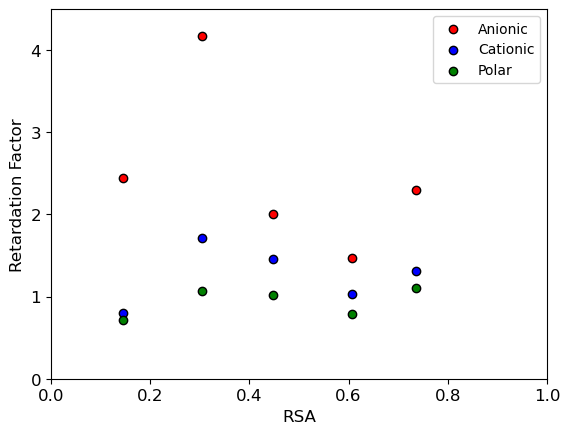

In [48]:
for i in ret_factors_sumo1_computed:
    plt.scatter(*ret_factors_sumo1_computed[i], c=i, label=labels[i], edgecolors='k')
plt.xlim(0,1)
plt.ylim(0,4.5)
plt.yticks(np.arange(0,5,1))
plt.legend()
plt.tick_params(labelsize=12)
plt.ylabel('Retardation Factor',size=12)
plt.xlabel('RSA',size=12)
plt.savefig('./Retardation_factor_sumo1_w0.25_s0.16.png',dpi=300)

In [49]:
unique_type = ['Non-polar', 'Polar', 'Cationic', 'Anionic']
unique_type2 = [i.lower() for i in unique_type]
unique_type2[0]='nonpolar'

In [50]:
dict_boxplot_sumo1 = {i:sumo1_df[sumo1_df['type']==i][sumo1_df['RSA']<0.2][symbols['tau']] for i in unique_type}
dict_boxplot_sumo1_2 = {i:sumo1_df[sumo1_df['type']==i][(sumo1_df['RSA']>0.2)&(sumo1_df['RSA']<0.4)][symbols['tau']] for i in unique_type}
dict_boxplot_sumo1_4 = {i:sumo1_df[sumo1_df['type']==i][(sumo1_df['RSA']>0.4)&(sumo1_df['RSA']<0.6)][symbols['tau']] for i in unique_type}
dict_boxplot_sumo1_6 = {i:sumo1_df[sumo1_df['type']==i][(sumo1_df['RSA']>0.6)&(sumo1_df['RSA']<0.8)][symbols['tau']] for i in unique_type}
dict_boxplot_sumo1_8 = {i:sumo1_df[sumo1_df['type']==i][sumo1_df['RSA']>0.8][symbols['tau']] for i in unique_type}

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


$\mathbf{Figure\; 13}$

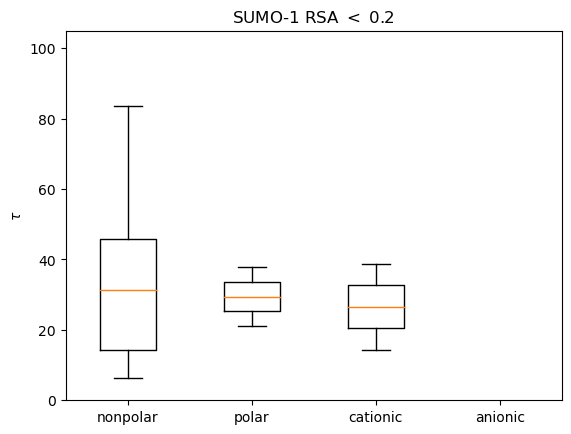

In [51]:
plt.boxplot([dict_boxplot_sumo1[i] for i in dict_boxplot_sumo1])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'SUMO-1 RSA $<$ 0.2')
plt.savefig('./boxplot_tau_sumo1_lt2_restype.png', dpi=300)

$\mathbf{Figure\; 14}$

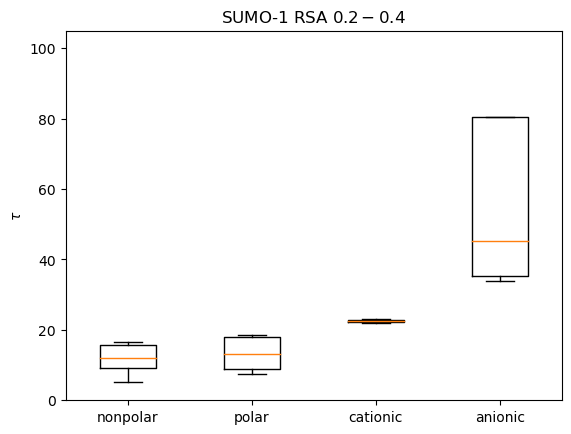

In [52]:
plt.boxplot([dict_boxplot_sumo1_2[i] for i in dict_boxplot_sumo1])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'SUMO-1 RSA $0.2-0.4$ ')
plt.savefig('./boxplot_tau_sumo1_2-4_restype.png', dpi=300)

$\mathbf{Figure\; 15}$

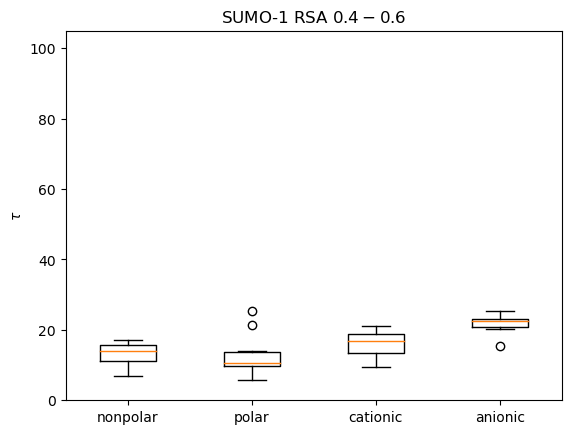

In [53]:
plt.boxplot([dict_boxplot_sumo1_4[i] for i in dict_boxplot_sumo1])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'SUMO-1 RSA $0.4-0.6$ ')
plt.savefig('./boxplot_tau_sumo1_4-6_restype.png', dpi=300)

$\mathbf{Figure\; 16}$

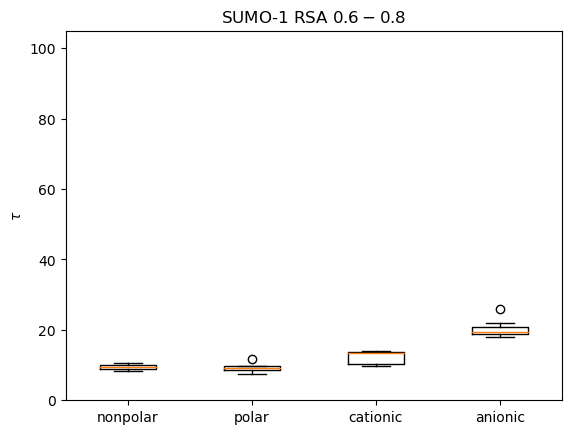

In [54]:
plt.boxplot([dict_boxplot_sumo1_6[i] for i in dict_boxplot_sumo1])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'SUMO-1 RSA $0.6-0.8$ ')
plt.savefig('./boxplot_tau_sumo1_4-6_restype.png', dpi=300)

$\mathbf{Figure\; 17}$

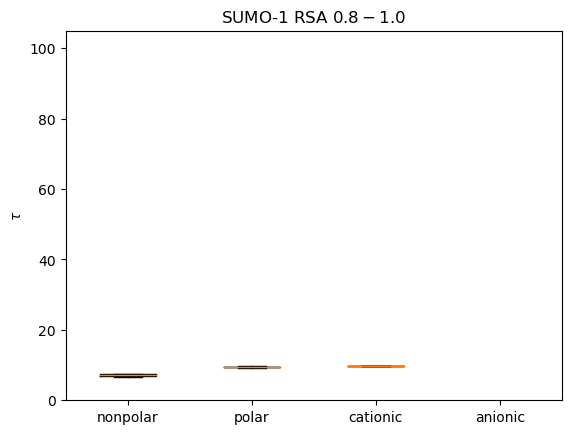

In [55]:
plt.boxplot([dict_boxplot_sumo1_8[i] for i in dict_boxplot_sumo1])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'SUMO-1 RSA $0.8-1.0$ ')
plt.savefig('./boxplot_tau_sumo1_8_restype.png', dpi=300)

$\mathbf{Oneway\; ANOVA\; SUMO-1}$

In [56]:
stats.f_oneway(dict_boxplot_sumo1['Non-polar'],dict_boxplot_sumo1['Polar'],dict_boxplot_sumo1['Cationic'])

F_onewayResult(statistic=0.13311641871902266, pvalue=0.876385793564363)

$\mathbf{Figure\; 18}$

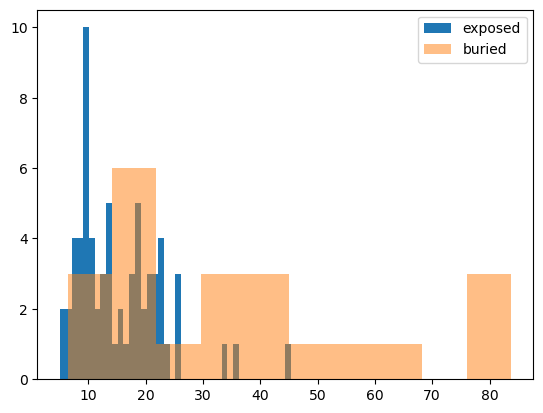

In [57]:
buried = sumo1_df[sumo1_df['RSA']<0.23]
exposed = sumo1_df[sumo1_df['RSA']>=0.23]
plt.hist(exposed[symbols['tau']].values,histtype='barstacked',bins=40,label='exposed')
plt.hist(buried[symbols['tau']].values,histtype='barstacked',bins=10,alpha=0.5,label='buried')
plt.legend()
plt.savefig('./histogram_sumo1.png',dpi=300)

# UBC-9

In [58]:
reg_struct_ubc9 = pd.read_csv('./UBC9/regions_structure.txt')

In [59]:
reg_struct_ubc9

,struct,start,stop
0,IDR,1,5
1,HELIX,6,17
2,LOOP,18,23
3,BETA,24,30
4,LOOP,31,35
5,BETA,36,46
6,IDR,47,55
7,BETA,56,62
8,IDR,63,73
9,BETA,74,76


In [60]:
ubc9_df = pd.read_csv('./UBC9/RSA_res_name_type.csv').drop(columns='Unnamed: 0')
# ubc9_df.drop(columns='Unnamed: 0',inplace=True)
ubc9_df[symbols['tau']] = pd_saveit_ubc9[symbols['tau']].values
ubc9_df[symbols['sigma']] = pd_saveit_ubc9[symbols['sigma']].values
ubc9_df['ci_99'] = t.interval(alpha=0.99, scale=pd_saveit_ubc9[symbols['sigma']].values, df = tau_err_stack_ubc9.transpose(1,2,0)[:,-1,-1])[-1]
ubc9_df['struct'] = [j[0] for i in ubc9_df['residue'].values for j in reg_struct_ubc9.values if i>=j[1] and i<=j[2]]
ubc9_df['shape'] = [ markers[i] for i in ubc9_df['struct'].values]
ubc9_df['electro'] = [ res_to_elect[i] for i in ubc9_df['name'].values ]

Reported here with error bars is the 99% confidence interval of

$tau_{HB}$ for the full lentgh trajectory

$\mathbf{Figure\; 19}$

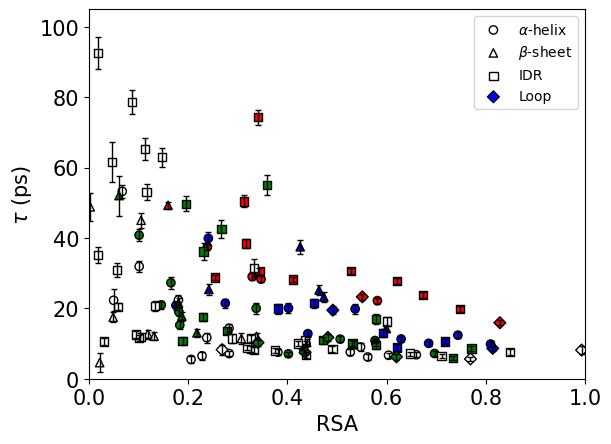

In [61]:
dfout = pd.DataFrame()
for i in ['HELIX','BETA','IDR','LOOP']:
    dfout_temp = pd.DataFrame()
    TF =  ( ubc9_df['struct']==i )
    x = ubc9_df[TF][symbols['tau']].values
    xerr = ubc9_df[TF]['ci_99'].values
    y = ubc9_df[TF]['RSA'].values
    z = ubc9_df[TF]['residue'].values
    z2 = ubc9_df[TF]['name'].values
    z3 = list(map(lambda k: labels[k], ubc9_df[TF]['electro'].values))
    
    color_it = ubc9_df[TF]['electro'].values
    plt.errorbar(y, x, yerr=xerr, color='white', alpha=1, ecolor='k', capsize=2, linewidth=0, elinewidth=1)
    if i != 'white': plt.scatter(y, x, c=color_it , marker=markers[i], label=label_it[i], edgecolors='k')
    else:plt.scatter(y, x, c='grey' , marker=markers[i], label=label_it[i], edgecolors='k')
    dfout_temp = pd.DataFrame()
    dfout_temp['tau']=x
    dfout_temp['RSA']=y
    dfout_temp['residue']=z
    dfout_temp['number']=z2
    dfout_temp['type']=z3
    dfout = pd.concat([dfout,dfout_temp], ignore_index=True, sort=False)
dfout.to_csv('./tau_v_RSA_colorbyelectro-ubc9.csv')
plt.ylim(0,105)
plt.xlim(0,1)
plt.xlabel('RSA',size=15)
plt.ylabel(r'$\tau$ (ps)', size=15)
plt.tick_params(labelsize=15)
plt.legend()
plt.savefig('./tau_v_RSA_colorbyelectro_withCI99-ubc9.png',dpi= 300)

$\mathbf{Figure\; 20}$

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


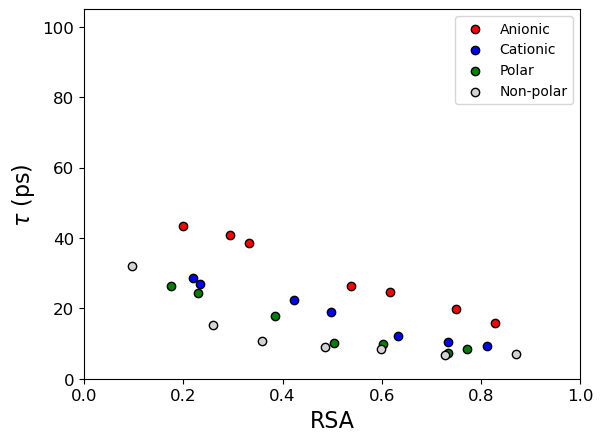

In [62]:
dict_MW_electro_ubc9 = {}
for i in ['r','b','g','white']:
    TF = ( ubc9_df['electro']==i )
    y = ubc9_df[TF][symbols['tau']].values
    x = ubc9_df[TF]['RSA'].values
    xy, n = moving_average(x,y,0.25,0.125,[0.0,1.0])
    n = np.array(n)
    x,y = xy.T

    if i != 'white': plt.scatter(x, y, c=i, label=labels[i],edgecolors='k')
    else: plt.scatter(x, y, c='lightgrey', label=labels[i],edgecolors='k')
    
    dict_MW_electro_ubc9[i]=np.array([x, y, n, i*len(y)])


plt.ylim(0,105)
plt.xlim(0,1)
plt.tick_params(labelsize=12)
plt.xlabel('RSA',size=16)
plt.ylabel(r'$\tau$ (ps)',size=16)
plt.legend()
plt.savefig('./tau_v_RSA_MW_colorbyelectro-ubc9.png',dpi= 300)

$\mathbf{Figure\; 21}$

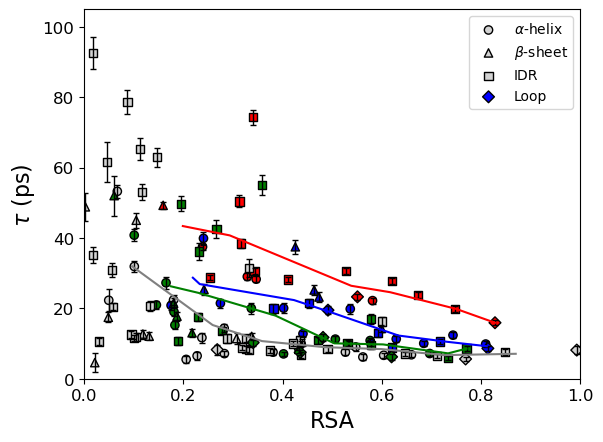

In [63]:
for i in ['HELIX','BETA','IDR','LOOP']:
    dfout_temp = pd.DataFrame()
    TF =  ( ubc9_df['struct']==i )
    x = ubc9_df[TF][symbols['tau']].values
    xerr = ubc9_df[TF]['ci_99'].values
    y = ubc9_df[TF]['RSA']

    color_it = ubc9_df[TF]['electro'].values
    temp = np.array([i if i != 'white' else 'lightgrey' for i in color_it ])
    color_it = temp
    plt.errorbar(y, x, yerr=xerr, alpha=1, ecolor='k', capsize=2, linewidth=0, elinewidth=1)
    plt.scatter(y, x, c=color_it , marker=markers[i], label=label_it[i], edgecolors='k')
    
for i in ['r','b','g','white']:
    if i != 'white': plt.plot(dict_MW_electro_ubc9[i][0],dict_MW_electro_ubc9[i][1], c = i)
    else: plt.plot(dict_MW_electro_ubc9[i][0],dict_MW_electro_ubc9[i][1], c = 'grey')

plt.ylim(0,105)
plt.xlim(0,1)
plt.tick_params(labelsize=12)
plt.xlabel('RSA',size=16)
plt.ylabel(r'$\tau$ (ps)',size=16)
plt.legend()
plt.savefig('./tau_v_RSA_colorbyelectro_withMW_withCI-ubc9.png',dpi= 300)

$\mathbf{Figure\; 22}$

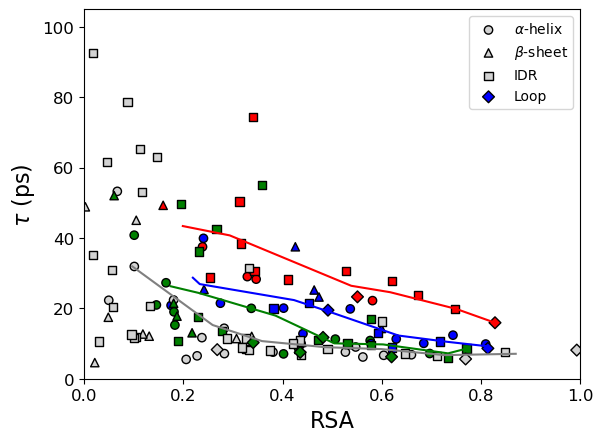

In [64]:
dfout = pd.DataFrame()

for i in ['HELIX','BETA','IDR','LOOP']:
    dfout_temp = pd.DataFrame()
    TF =  ( ubc9_df['struct']==i )
    x = ubc9_df[TF][symbols['tau']].values
    y = ubc9_df[TF]['RSA'].values

    color_it = ubc9_df[TF]['electro'].values
    temp = np.array([i if i != 'white' else 'lightgrey' for i in color_it ])
    color_it = temp
    #Plot data without 99% CI
    plt.scatter(y, x, c=color_it , marker=markers[i], label=label_it[i], edgecolors='k')


# Plot Moving window average
for i in ['r','b','g','white']:
    if i != 'white': plt.plot(dict_MW_electro_ubc9[i][0],dict_MW_electro_ubc9[i][1], color = i)
    else: plt.plot(dict_MW_electro_ubc9[i][0],dict_MW_electro_ubc9[i][1], color = 'grey')

plt.ylim(0,105)
plt.xlim(0,1)
plt.tick_params(labelsize=12)
plt.xlabel('RSA',size=16)
plt.ylabel(r'$\tau$ (ps)',size=16)
plt.legend()
plt.savefig('./tau_v_RSA_colorbyelectro_withMW-ubc9.png',dpi= 300)

$\mathbf{Figure\; 23}$

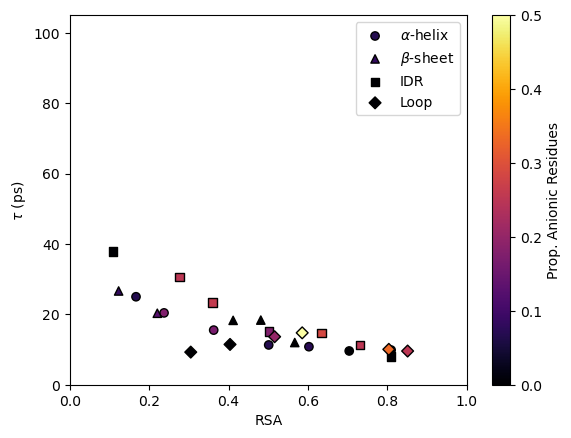

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in label_it:
    TF = (ubc9_df[symbols['tau']]>0.0) & ( ubc9_df['struct']==i )
    x = ubc9_df[TF][symbols['tau']].values
    y = ubc9_df[TF]['RSA'].values
    z = ubc9_df[TF]['electro'].values
    y, x, z = moving_average_ptype(y, x, z, 0.25, 0.125, [0.0,1.0]).T
    plt.scatter(y, x, c=z, cmap="inferno", marker=markers[i], label=label_it[i], edgecolors='k', vmax=0.5, vmin=0)


plt.ylim(0,105)
plt.xlim(0,1)
plt.xlabel('RSA')
plt.ylabel(r'$\tau$ (ps)')
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Prop. Anionic Residues')
plt.savefig('./tau_RSA_Anionic_2D_MW_region-ubc9.png',dpi=300)

Compute Average tau,RSA using a mindow of 0.25 and a step size of 0.16

In [66]:
ret_factors_ubc9 = {}
for i in ['r','b','g','white']:
    TF = ( ubc9_df['electro']==i )
    y = ubc9_df[TF][symbols['tau']].values
    x = ubc9_df[TF]['RSA'].values
    
    ret_factors_ubc9[i], _=moving_average(x, y,  prop=0.25, step=0.16, minmax=[0,1])    

In [67]:
ret_mean = []
ret_factors_ubc9_computed = {}
for i in ret_factors_sumo1:
    ret_mean.append(ret_factors_ubc9[i][:,0])
ret_mean = np.mean(ret_mean,axis=0)
for i in ret_factors_ubc9:
    if i != 'white':
        ret_factors_ubc9_computed[i] = np.array([ret_mean,ret_factors_ubc9[i][:,1]/ret_factors_ubc9['white'][:,1]])

$\mathbf{Figure\; 24}$

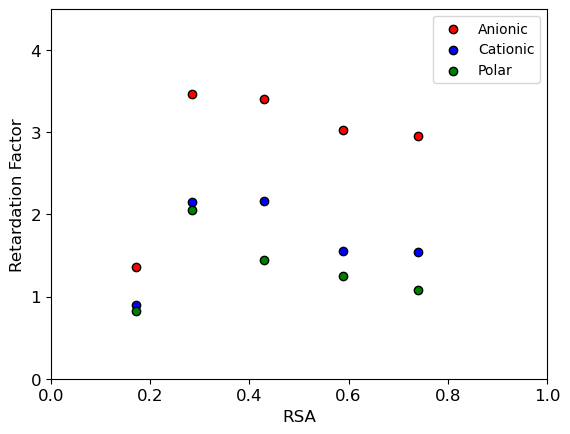

In [68]:
for i in ret_factors_ubc9_computed:
    plt.scatter(*ret_factors_ubc9_computed[i], c=i, label=labels[i], edgecolors='k')
plt.xlim(0,1)
plt.ylim(0,4.5)
plt.yticks(np.arange(0,5,1))
plt.legend()
plt.tick_params(labelsize=12)
plt.ylabel('Retardation Factor',size=12)
plt.xlabel('RSA',size=12)
plt.savefig('./Retardation_factor_ubc9_w0.25_s0.16.png',dpi=300)

In [69]:
unique_type = ['Non-polar', 'Polar', 'Cationic', 'Anionic']
unique_type2 = [i.lower() for i in unique_type]
unique_type2[0]='nonpolar'

In [70]:
dict_boxplot_ubc9 = {i:ubc9_df[ubc9_df['type']==i][ubc9_df['RSA']<0.2][symbols['tau']] for i in unique_type}
dict_boxplot_ubc9_2 = {i:ubc9_df[ubc9_df['type']==i][(ubc9_df['RSA']>0.2)&(ubc9_df['RSA']<0.4)][symbols['tau']] for i in unique_type}
dict_boxplot_ubc9_4 = {i:ubc9_df[ubc9_df['type']==i][(ubc9_df['RSA']>0.4)&(ubc9_df['RSA']<0.6)][symbols['tau']] for i in unique_type}
dict_boxplot_ubc9_6 = {i:ubc9_df[ubc9_df['type']==i][(ubc9_df['RSA']>0.6)&(ubc9_df['RSA']<0.8)][symbols['tau']] for i in unique_type}
dict_boxplot_ubc9_8 = {i:ubc9_df[ubc9_df['type']==i][(ubc9_df['RSA']>0.8)][symbols['tau']] for i in unique_type}

/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/koreyr/miniconda3/envs/MDA/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


$\mathbf{Figure\; 25}$

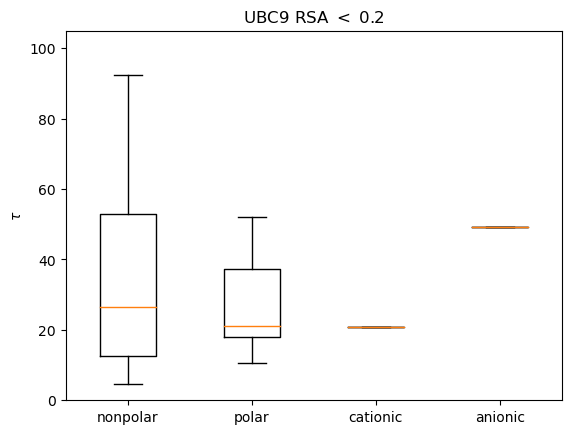

In [78]:
plt.boxplot([dict_boxplot_ubc9[i] for i in dict_boxplot_ubc9])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'UBC9 RSA $<$ 0.2')
plt.savefig('./boxplot_tau_ubc9_lt2_restype.png', dpi=300)

$\mathbf{Figure\; 26}$

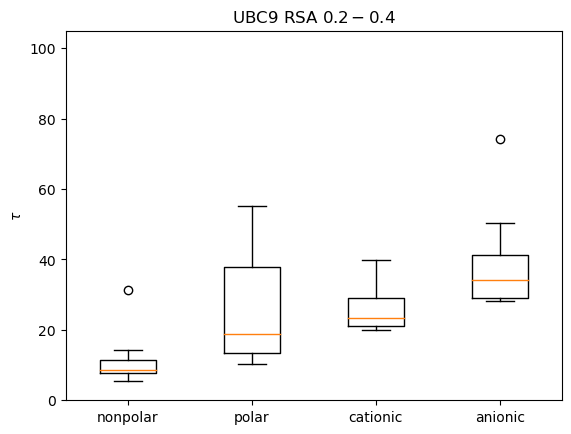

In [72]:
plt.boxplot([dict_boxplot_ubc9_2[i] for i in dict_boxplot_ubc9])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'UBC9 RSA $0.2-0.4$')
plt.savefig('./boxplot_tau_ubc9_2-4_restype.png', dpi=300)

$\mathbf{Figure\; 27}$

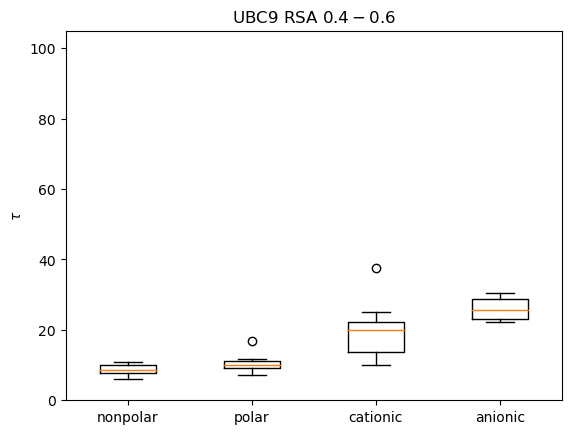

In [73]:
plt.boxplot([dict_boxplot_ubc9_4[i] for i in dict_boxplot_ubc9])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'UBC9 RSA $0.4-0.6$')
plt.savefig('./boxplot_tau_ubc9_4-6_restype.png', dpi=300)

$\mathbf{Figure\; 28}$

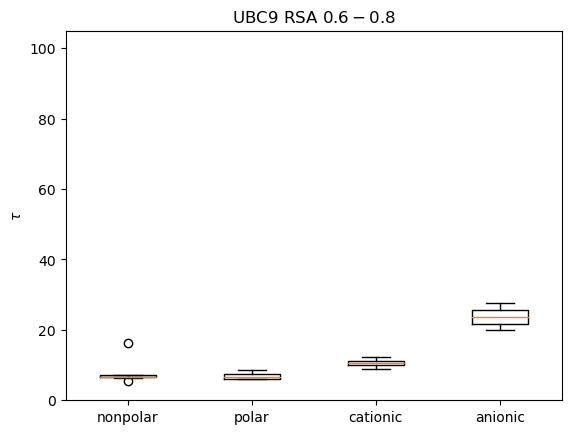

In [74]:
plt.boxplot([dict_boxplot_ubc9_6[i] for i in dict_boxplot_ubc9])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'UBC9 RSA $0.6-0.8$')
plt.savefig('./boxplot_tau_ubc9_6-8_restype.png', dpi=300)

$\mathbf{Figure\; 29}$

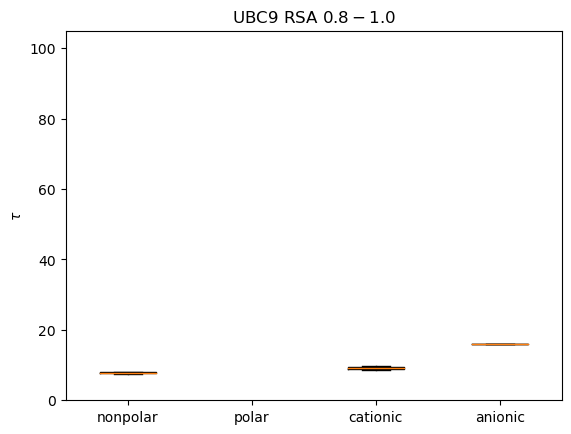

In [75]:
plt.boxplot([dict_boxplot_ubc9_8[i] for i in dict_boxplot_ubc9])
plt.xticks(np.arange(1,5),unique_type2)
plt.ylim(0,105)
plt.ylabel(r'$\tau$')
plt.title(r'UBC9 RSA $0.8-1.0$')
plt.savefig('./boxplot_tau_ubc9_gt8_restype.png', dpi=300)

$\mathbf{Oneway \; ANOVA \; UBC9}$

In [76]:
stats.f_oneway(dict_boxplot_ubc9['Non-polar'],dict_boxplot_ubc9['Polar'],dict_boxplot_ubc9['Cationic'],dict_boxplot_ubc9['Anionic'])

F_onewayResult(statistic=0.5461048927836233, pvalue=0.6543450524638996)

$\mathbf{Figure\; 30}$

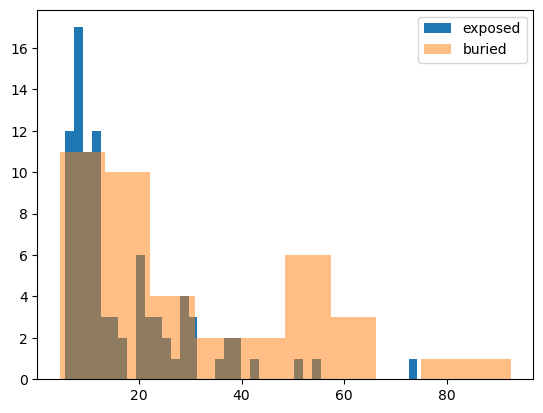

In [77]:
buried = ubc9_df[ubc9_df['RSA']<0.23]
exposed = ubc9_df[ubc9_df['RSA']>=0.23]
plt.hist(exposed[symbols['tau']].values,histtype='barstacked',bins=40,label='exposed')
plt.hist(buried[symbols['tau']].values,histtype='barstacked',bins=10,alpha=0.5,label='buried')
plt.legend()
plt.savefig('./histogram_ubc9.png',dpi=300)